<a href="https://colab.research.google.com/github/spurthi1886/ADM_PROJECT/blob/main/Mobile_Price_Predictor_with_Random_Forest_(1886_BT_30).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Loading, Preprocessing, and Cleaning

In [ ]:
#  Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, classification_report

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Load dataset
df = pd.read_csv('Mobiles_Dataset_2025.csv', encoding='latin1')
print(" Initial Dataset:")
print(df.head())  # See the first few rows of raw data

# Step 1: Remove Duplicates and Handle Missing Values
df.drop_duplicates(inplace=True)
df.ffill(inplace=True)

#  Step 2: Clean 'RAM' and 'Battery Capacity' columns
df['RAM'] = df['RAM'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
df['Battery Capacity'] = df['Battery Capacity'].astype(str).str.replace(',', '').str.extract('(\d+\.?\d*)').astype(float)

#  Step 3: Clean 'Launched Price (India)' by removing ₹, commas, etc.
df['Launched Price (India)'] = (
    df['Launched Price (India)']
    .astype(str)
    .str.replace('₹', '')
    .str.replace('INR', '')
    .str.replace(',', '')
    .str.extract('(\d+\.?\d*)')[0]
    .astype(float)
)

#  Step 4: Clean 'Screen Size'
df['Screen Size'] = df['Screen Size'].astype(str).str.extract(r'(\d+\.?\d*)').astype(float)

# Step 5: Clean 'Front Camera'
df['Front Camera'] = df['Front Camera'].astype(str).str.extract(r'(\d+\.?\d*)').astype(float)

#  Step 6: Clean 'Back Camera' with Multiple Lenses
def extract_max_camera(value):
    if isinstance(value, str):
        nums = [float(n) for n in re.findall(r'\d+\.?\d*', value)]
        return max(nums) if nums else None
    return value

df['Back Camera'] = df['Back Camera'].apply(extract_max_camera)

#  Step 7: Clean other international price columns
price_cols = [
    'Launched Price (Pakistan)', 'Launched Price (China)',
    'Launched Price (USA)', 'Launched Price (Dubai)'
]

for col in price_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(r'[^\d\.]', '', regex=True)
        .str.extract('(\d+\.?\d*)')[0]
        .astype(float)
    )


 Initial Dataset:
  Company Name            Model Name Mobile Weight  RAM Front Camera  \
0        Apple       iPhone 16 128GB          174g  6GB         12MP   
1        Apple       iPhone 16 256GB          174g  6GB         12MP   
2        Apple       iPhone 16 512GB          174g  6GB         12MP   
3        Apple  iPhone 16 Plus 128GB          203g  6GB         12MP   
4        Apple  iPhone 16 Plus 256GB          203g  6GB         12MP   

  Back Camera   Processor Battery Capacity Screen Size  \
0        48MP  A17 Bionic         3,600mAh  6.1 inches   
1        48MP  A17 Bionic         3,600mAh  6.1 inches   
2        48MP  A17 Bionic         3,600mAh  6.1 inches   
3        48MP  A17 Bionic         4,200mAh  6.7 inches   
4        48MP  A17 Bionic         4,200mAh  6.7 inches   

  Launched Price (Pakistan) Launched Price (India) Launched Price (China)  \
0               PKR 224,999             INR 79,999              CNY 5,799   
1               PKR 234,999             INR 84

--> Loads essential libraries for data analysis, visualization, cleaning, machine learning modeling, and evaluation.

-->Reads the mobile dataset into a DataFrame and displays the first 5 records.

S-I:Removes duplicate rows and fills missing values using forward fill (propagates last valid observation forward).

S-II:Extracts numeric values from 'RAM' and 'Battery Capacity', converting them to float format for analysis.

S-III:Removes currency symbols and formats to convert Indian price values into clean numeric form.

S-IV:Extracts the numeric inch value from potentially descriptive strings like "6.5 inches".

S-V:Extracts the megapixel value from possibly messy or descriptive camera specifications.

S-VI:Parses and returns the highest megapixel count from strings like "48MP + 8MP + 2MP".

S-VII:Strips currency symbols and non-numeric characters from international price fields and converts them to float.

In [ ]:
# Step 8:Encode Company Name
le = LabelEncoder()
df['Company_Encoded'] = le.fit_transform(df['Company Name'])

# Step 9: Filter Unrealistic RAM Values
df = df[df['RAM'] <= 12]

#  Step 10:Preview Cleaned Data
print("\nCleaned Dataset Preview:")
print(df.head())


Cleaned Dataset Preview:
  Company Name            Model Name Mobile Weight  RAM  Front Camera  \
0        Apple       iPhone 16 128GB          174g  6.0          12.0   
1        Apple       iPhone 16 256GB          174g  6.0          12.0   
2        Apple       iPhone 16 512GB          174g  6.0          12.0   
3        Apple  iPhone 16 Plus 128GB          203g  6.0          12.0   
4        Apple  iPhone 16 Plus 256GB          203g  6.0          12.0   

   Back Camera   Processor  Battery Capacity  Screen Size  \
0         48.0  A17 Bionic            3600.0          6.1   
1         48.0  A17 Bionic            3600.0          6.1   
2         48.0  A17 Bionic            3600.0          6.1   
3         48.0  A17 Bionic            4200.0          6.7   
4         48.0  A17 Bionic            4200.0          6.7   

   Launched Price (Pakistan)  Launched Price (India)  Launched Price (China)  \
0                   224999.0                 79999.0                  5799.0   
1       

S-VIII:Converts the categorical Company Name column (e.g., Samsung, Apple) into numeric labels so it can be used in machine learning models.

S-IX:Removes entries where RAM exceeds 12 GB, assuming those are rare or outliers for typical mobile use cases.

S-X:Displays the first few rows of the cleaned dataset to verify that transformations were applied correctly.

# Exploratory Data Analysis (EDA)


<ipython-input-3-18cf2b9754c6>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ram_counts.index, y=ram_counts.values, palette=colors)
<ipython-input-3-18cf2b9754c6>:33: UserWarning: Glyph 128241 (\N{MOBILE PHONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128241 (\N{MOBILE PHONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


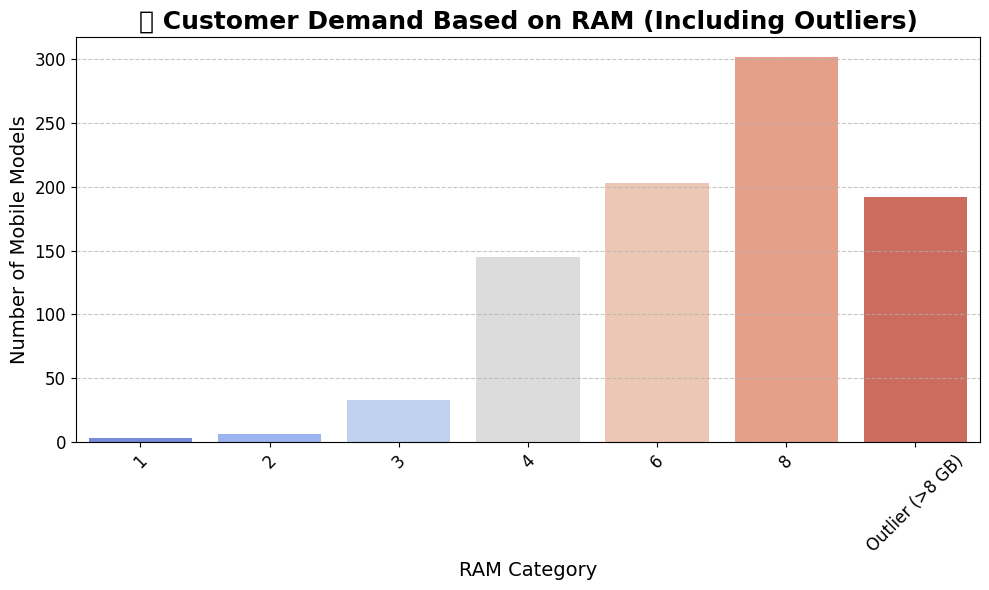

In [ ]:
# Step 10: Feature Scaling for Selected Columns
scaler = StandardScaler()
scale_cols = ['RAM', 'Screen Size', 'Battery Capacity', 'Launched Price (India)']
df_scaled = df.copy()
df_scaled[scale_cols] = pd.DataFrame(scaler.fit_transform(df[scale_cols]), columns=scale_cols)

# Step 11: EDA – Customer Demand Based on RAM

import seaborn as sns
import matplotlib.pyplot as plt

# 📌 Step 1: Round RAM Values
df['RAM_Rounded'] = df['RAM'].round()

# 🚫 Step 2: Categorize RAM > 8 GB as Outlier
df['RAM_Category'] = df['RAM'].apply(lambda x: str(int(x)) if x <= 8 else 'Outlier (>8 GB)')

# 📈 Step 3: Count Mobile Models Per RAM Category
ram_counts = df['RAM_Category'].value_counts().sort_index()

# Step 4: Bar Plot – RAM Demand
plt.figure(figsize=(10, 6))
colors = sns.color_palette("coolwarm", len(ram_counts))

sns.barplot(x=ram_counts.index, y=ram_counts.values, palette=colors)

# Make it sexy
plt.title("📱 Customer Demand Based on RAM (Including Outliers)", fontsize=18, weight='bold')
plt.xlabel("RAM Category", fontsize=14)
plt.ylabel("Number of Mobile Models", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Feature Scaling for Modeling:

-->Applies StandardScaler to selected numeric columns, transforming them to have zero mean and unit variance. This prepares the data for algorithms that are sensitive to scale (e.g., KMeans, SVM, Linear Regression).

Simplifying RAM Values for Visualization:


-->Rounds off RAM to the nearest whole number for clearer categorization and grouping in plots.


Outlier Categorization:

 -->Groups RAM sizes above 8 GB under a common label (Outlier (>8 GB)), treating them as less common.

 Category Frequency Calculation:

 -->Counts how many mobile models fall under each RAM category.

Data Visualization – RAM Demand Analysis:

-->Creates a styled bar chart showing how many models exist in each RAM category, visually representing customer demand and market distribution.

<ipython-input-4-c11f96b0bec0>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x="Launched Year", y="RAM", estimator='mean', ci=None, marker='o',


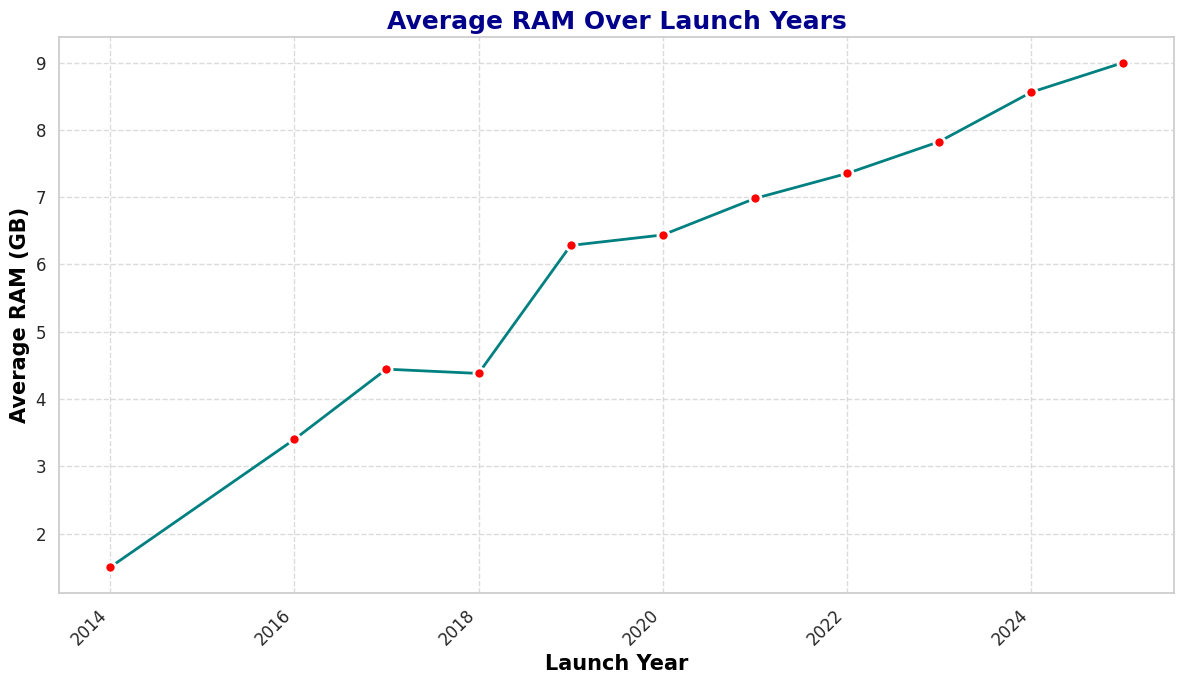

In [ ]:
# Set Seaborn plot style to white grid background
sns.set(style="whitegrid")

# Set figure size for better visualization
plt.figure(figsize=(12, 7))

# Clean RAM column by extracting numeric values (in GB)
df['RAM'] = df['RAM'].astype(str).str.extract(r'(\d+\.?\d*)').astype(float)

# Plot average RAM per launch year using a line plot
sns.lineplot(data=df, x="Launched Year", y="RAM", estimator='mean', ci=None, marker='o',
             color='teal', linewidth=2, markersize=8, markerfacecolor='red', markeredgewidth=2)

# Add chart title and axis labels with styling
plt.title("Average RAM Over Launch Years", fontsize=18, fontweight='bold', color='darkblue')
plt.xlabel("Launch Year", fontsize=15, fontweight='bold', color='black')
plt.ylabel("Average RAM (GB)", fontsize=15, fontweight='bold', color='black')

# Style x-axis and y-axis ticks for better readability
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)

# Enable horizontal grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to fit labels nicely
plt.tight_layout()

# Display the plot
plt.show()



 Aim:
To visualize the trend of average mobile RAM capacity over the years by plotting a line graph of RAM vs. Launched Year. This helps identify whether smartphone RAM has increased over time and by how much.

Insight:
This plot allows analysts or businesses to observe market evolution and technological growth in mobile memory. It’s useful for product planning, benchmarking, and understanding customer expectations over time.

In [ ]:
# Function to detect outliers using the IQR (Interquartile Range) method
def detect_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)               # 25th percentile (lower quartile)
    Q3 = df[feature].quantile(0.75)               # 75th percentile (upper quartile)
    IQR = Q3 - Q1                                        # Interquartile range
    lower_bound = Q1 - 1.5 * IQR               # Lower limit for outliers
    upper_bound = Q3 + 1.5 * IQR              # Upper limit for outliers
    return df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]  # Return outlier rows

# Detect outliers in RAM values
outliers_ram = detect_outliers(df, 'RAM')

# Detect outliers in Indian launch price
outliers_price = detect_outliers(df, 'Launched Price (India)')

 Aim:
To identify outliers in numerical columns (like RAM and Launched Price) using the Interquartile Range (IQR) method. Outliers can distort data analysis and model performance, so it's important to detect or handle them.

 Insight:
This technique helps detect unusually high or low values which may indicate errors, rare products, or premium devices. These can then be analyzed separately, cleaned, or capped depending on the use case.

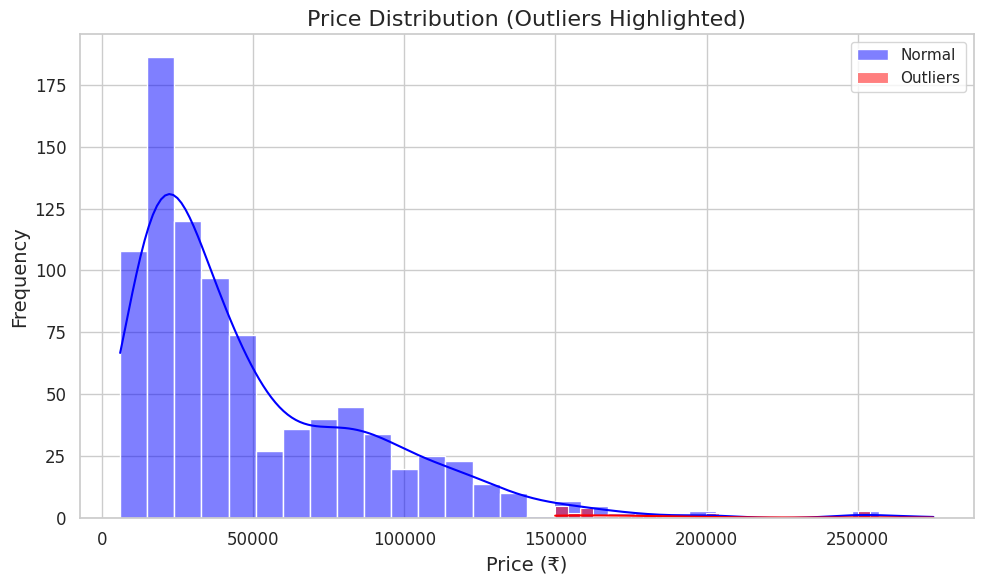

In [ ]:
#  Plotting histogram to show price distribution including outliers
plt.figure(figsize=(10, 6))  # Set figure size

# Plot normal price distribution (in blue)
sns.histplot(df['Launched Price (India)'], bins=30, kde=True, color='blue', label='Normal')

# Plot outlier prices (in red)
sns.histplot(outliers_price['Launched Price (India)'], bins=30, kde=True, color='red', label='Outliers')

# Add plot title and axis labels
plt.title("Price Distribution (Outliers Highlighted)", fontsize=16)
plt.xlabel("Price (₹)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Customize tick size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show legend and layout
plt.legend()
plt.tight_layout()

# Display the final plot
plt.show()


 Aim:
To visualize the distribution of mobile launch prices in India and clearly highlight the outlier price points using a histogram with kernel density estimation (KDE).

 Insight:
This helps in understanding the price spread in the market and identifies any unusual pricing trends (e.g., extremely cheap or expensive phones) that may affect analysis or model training.



<ipython-input-7-4619e2b27d24>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


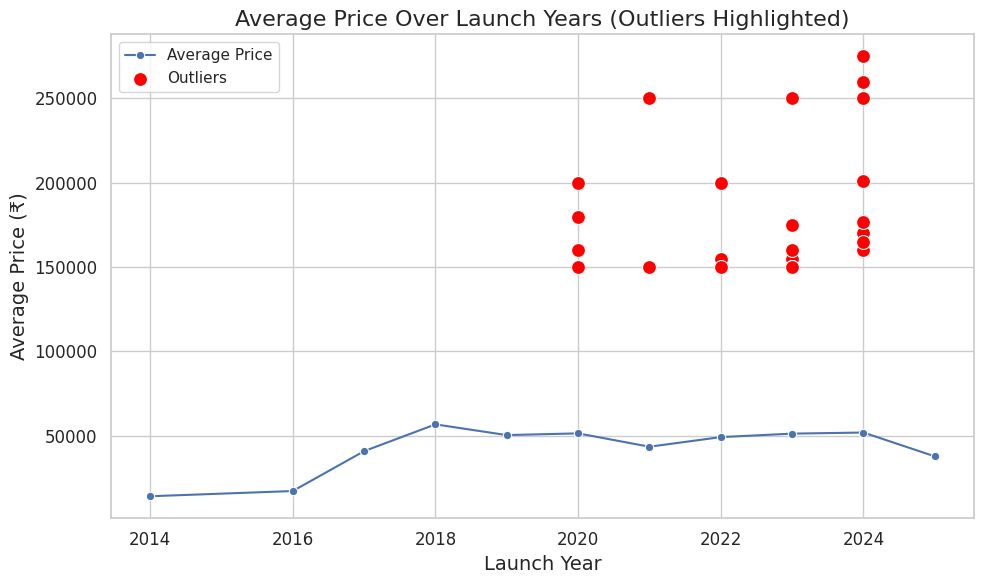

In [ ]:
#  Plotting Launch Year vs. Average Launch Price (highlighting outliers)
plt.figure(figsize=(10, 6))  # Set the figure size

# Line plot for average launch price per year
sns.lineplot(
    data=df, x="Launched Year", y="Launched Price (India)",
    estimator='mean', ci=None, marker='o', label='Average Price'
)

# Scatter plot to highlight outliers separately in red
sns.scatterplot(
    data=outliers_price, x="Launched Year", y="Launched Price (India)",
    color='red', label='Outliers', s=100  # Larger red dots for visibility
)

# Add plot title and labels
plt.title("Average Price Over Launch Years (Outliers Highlighted)", fontsize=16)
plt.xlabel("Launch Year", fontsize=14)
plt.ylabel("Average Price (₹)", fontsize=14)

# Customize tick font sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend and layout formatting
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()


Aim:
To visualize how the average launch price of mobiles has changed over different years, and highlight price outliers to detect anomalies or luxury product launches.

 Insight:
This plot shows both the general pricing trend over time and emphasizes any unusually priced models that may skew analysis or reflect premium segments. It helps in time-based trend analysis for pricing strategy or forecasting.

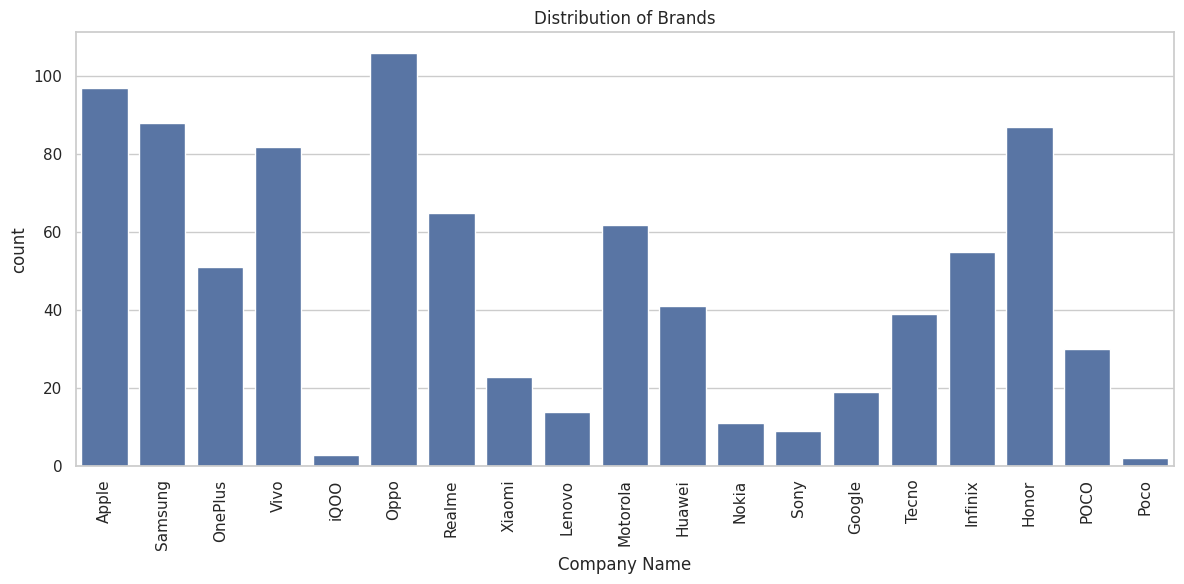

In [ ]:
# Plot the count of mobiles per brand (brand distribution)
plt.figure(figsize=(12, 6))  # Set plot size for readability

# Count plot showing number of products per company
sns.countplot(x='Company Name', data=df)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Add plot title
plt.title("Distribution of Brands")

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()


Aim:
To display the number of mobile models launched by each brand/company using a count plot.

Insight:
This visualization helps identify which brands dominate the market, which ones are less active, and offers a quick overview of brand-wise distribution in the dataset.

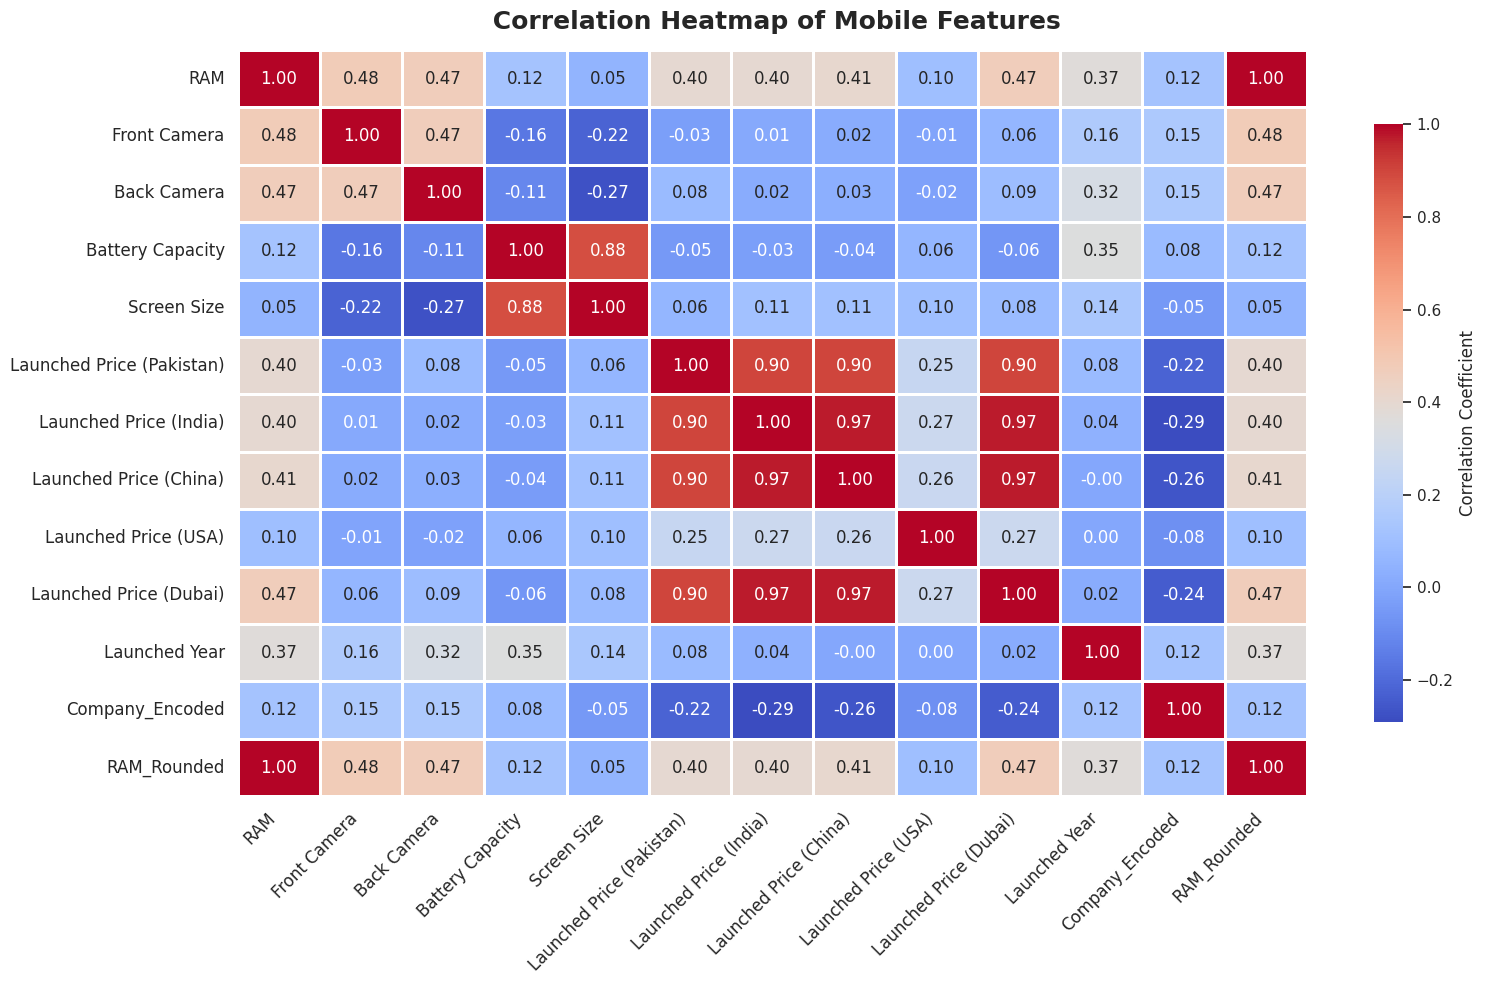

In [ ]:
#Compute correlation matrix of all numeric features
corr_matrix = df.corr(numeric_only=True).round(2)

#   Set larger figure for clearer and wider heatmap
plt.figure(figsize=(16, 10))

# : Draw heatmap with enhanced style
sns.heatmap(
    corr_matrix,
    annot=True,              # Show correlation values
    cmap='coolwarm',         # Use a diverging colormap
    fmt='.2f',               # Show values with 2 decimal places
    linewidths=1,            # White grid lines for separation
    linecolor='white',       # Line color
    square=False,            # Allow flexible cell shape
    cbar_kws={'shrink': 0.8, 'label': 'Correlation Coefficient'},  # Smaller color bar with label
    annot_kws={"size": 12}   # Larger annotation text
)

#  Add title and adjust layout
plt.title(' Correlation Heatmap of Mobile Features', fontsize=18, weight='bold', pad=15)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


 Aim:
To visualize the correlation strength between numeric mobile features (e.g., RAM, Battery, Price, Camera specs) using a heatmap.

 Insight:
This helps identify strong positive or negative relationships (e.g., price vs. RAM or screen size), which are useful for feature selection in machine learning or understanding feature importance in analysis.

<ipython-input-10-c5a29a69d510>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Launched Price (India)'], shade=True, color="blue")


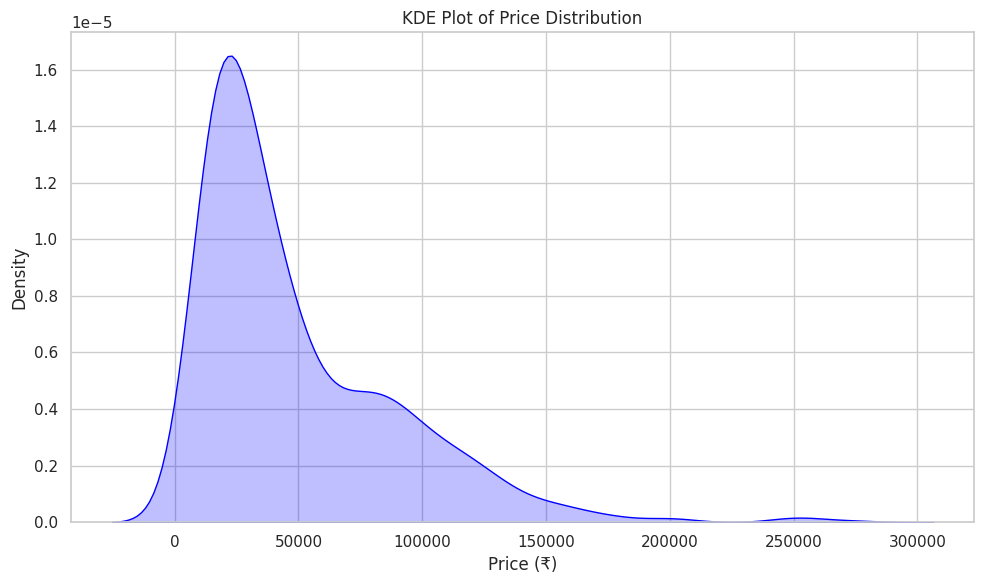

In [ ]:
#  Plotting Kernel Density Estimation (KDE) of launch price
plt.figure(figsize=(10, 6))  # Set plot size

# Create KDE plot to show smooth price distribution curve
sns.kdeplot(df['Launched Price (India)'], shade=True, color="blue")

# Add title and axis labels
plt.title("KDE Plot of Price Distribution")
plt.xlabel("Price (₹)")
plt.ylabel("Density")

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


 Aim:
To plot a KDE (Kernel Density Estimation) curve for the Launched Price (India) column, showing a smooth probability distribution of price values.

 Insight:
KDE plots help to visualize the shape of the data distribution, identify skewness, and understand where prices are concentrated (e.g., budget, midrange, premium segments).

# Model Preparation ,Training and Evaluation

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Define numeric columns to scale
numeric_cols = ['RAM', 'Screen Size', 'Battery Capacity', 'Front Camera', 'Back Camera']

# Normalize numeric input features
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


#  Select features and target variable
features = ['RAM', 'Screen Size', 'Battery Capacity', 'Front Camera', 'Back Camera', 'Company_Encoded']
target = 'Launched Price (India)'

# Split into input X and output y
X = df[features]
y = df[target]

#  Split data into training and testing sets (80-20 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Train Random Forest Regression model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Evaluate model performance
print("R² Score:", r2_score(y_test, y_pred))                 # Goodness of fit
print("MAE:", mean_absolute_error(y_test, y_pred))           # Average absolute error
print("MSE:", mean_squared_error(y_test, y_pred))            # Average squared error

R² Score: 0.9195602686815829
MAE: 7746.174978205645
MSE: 135696119.79147714


 Aim:
The goal of this code is to train a Random Forest Regression model to predict the launch price of mobile phones in India based on features like RAM, screen size, battery capacity, camera specifications, and company. By using the MinMaxScaler, all numeric features are normalized to a common range for better model performance. The dataset is split into training and testing sets (80-20 ratio), and the model is trained using the training set to predict prices on the test set. Model performance is evaluated using R² (Goodness of fit), MAE (Mean Absolute Error), and MSE (Mean Squared Error).

 Insight:
This approach leverages Random Forest Regression — an ensemble machine learning model known for handling complex datasets with multiple features and capturing non-linear relationships. The metrics used (R², MAE, MSE) offer insights into how accurately the model is predicting mobile prices. A high R² score suggests good fit, while lower MAE and MSE values indicate better model precision. Normalizing the input features helps ensure that no single feature (like RAM or screen size) disproportionately influences the model due to differing scales.

# Interactive Prediction Web Interface with Gradio

In [ ]:
#  Gradio Web Interface for prediction
!pip install gradio --quiet
import gradio as gr

# Generate sorted list of brand names for dropdown
company_list = sorted(df['Company Name'].unique().tolist())

# Prediction function using user inputs
def predict_price(ram, screen, battery, front_cam, back_cam, company_name):
    encoded_company = le.transform([company_name])[0]
    input_data = np.array([[ram, screen, battery, front_cam, back_cam, encoded_company]])
    input_scaled = scaler.transform(input_data[:, :5])  # Normalize numerical part
    final_input = np.concatenate((input_scaled, input_data[:, 5:]), axis=1)  # Combine with encoded company
    predicted_price = rf.predict(final_input)[0]
    return f" Estimated Price in India: ₹{int(predicted_price):,}"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.1 MB/s eta 0:00:00


Aim:
The purpose of this code is to create a Gradio web interface for the mobile price prediction model. Users can input key features of a mobile (RAM, screen size, battery, camera specifications, and company) through sliders and a dropdown. The prediction function processes these inputs, applies normalization (using the previously defined MinMaxScaler), and uses the trained Random Forest Regression model to predict the mobile's launch price in India. The result is displayed to the user in a user-friendly format.

 Insight:
Gradio makes it easy to create interactive UIs for machine learning models, enabling users to input real-world data and instantly get predictions. By using sliders for continuous features (like RAM and battery) and a dropdown for categorical data (company name), users get an intuitive way to interact with the model. The predicted price provides actionable insights, especially for e-commerce, product pricing, and market analysis.

In [ ]:
#  Gradio app layout
iface = gr.Interface(
    fn=predict_price,
    inputs=[
        gr.Slider(1, 16, step=1, label="RAM (GB)"),
        gr.Slider(4.0, 7.5, step=0.1, label="Screen Size (inches)"),
        gr.Slider(1000, 7000, step=100, label="Battery (mAh)"),
        gr.Slider(0, 64, step=1, label="Front Camera (MP)"),
        gr.Slider(5, 200, step=1, label="Back Camera (MP)"),
        gr.Dropdown(choices=company_list, label="Company Name")
    ],
    outputs="text",
    title="📱 Mobile Price Predictor (India)",
    description="Enter mobile specs to get an estimated launch price in ₹INR."
)

#  Launch Gradio interface
iface.launch(debug=True)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://480d27bdfe6aeb924b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Using existing dataset file at: .gradio/flagged/dataset1.csv
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://15554ab70a3a8d53b8.gradio.live
Killing tunnel 127.0.0.1:7860 <> https://480d27bdfe6aeb924b.gradio.live


Aim:
This code launches a Gradio web interface for the mobile price prediction model. The app takes multiple inputs from the user, including RAM, screen size, battery capacity, front and back camera specifications, and company name, and displays an estimated launch price for a mobile in India. Gradio allows users to interactively provide inputs via sliders and dropdown menus and get the predicted output in real time.

 Insight:
Gradio provides a simple and quick way to create a front-end interface for machine learning models, making them accessible to non-technical users. The app is designed to help users input mobile specifications and instantly get a price estimate based on the trained regression model. This can be helpful for users looking to make informed decisions about mobile purchases or for e-commerce platforms that need a price prediction system.

In [ ]:
# Categorize price into 4 classes
bins = [0, 5000, 15000, 30000, float('inf')]
labels = ['Low', 'Medium', 'High', 'Very High']
df['Price Category'] = pd.cut(df['Launched Price (India)'], bins=bins, labels=labels)

# Target for classification
y_cls = df['Price Category']
X_cls = df[features]  # Same features from your regression model


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC(),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"\n {name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds))
    results[name] = acc



 Random Forest Accuracy: 0.8475
              precision    recall  f1-score   support

        High       0.76      0.72      0.74        53
      Medium       0.79      0.77      0.78        30
   Very High       0.91      0.95      0.93        94

    accuracy                           0.85       177
   macro avg       0.82      0.81      0.81       177
weighted avg       0.84      0.85      0.85       177


 Logistic Regression Accuracy: 0.6723
              precision    recall  f1-score   support

        High       0.53      0.43      0.48        53
      Medium       0.75      0.70      0.72        30
   Very High       0.71      0.80      0.75        94

    accuracy                           0.67       177
   macro avg       0.66      0.64      0.65       177
weighted avg       0.66      0.67      0.66       177


 Decision Tree Accuracy: 0.8023
              precision    recall  f1-score   support

        High       0.67      0.68      0.67        53
      Medium       0.74 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


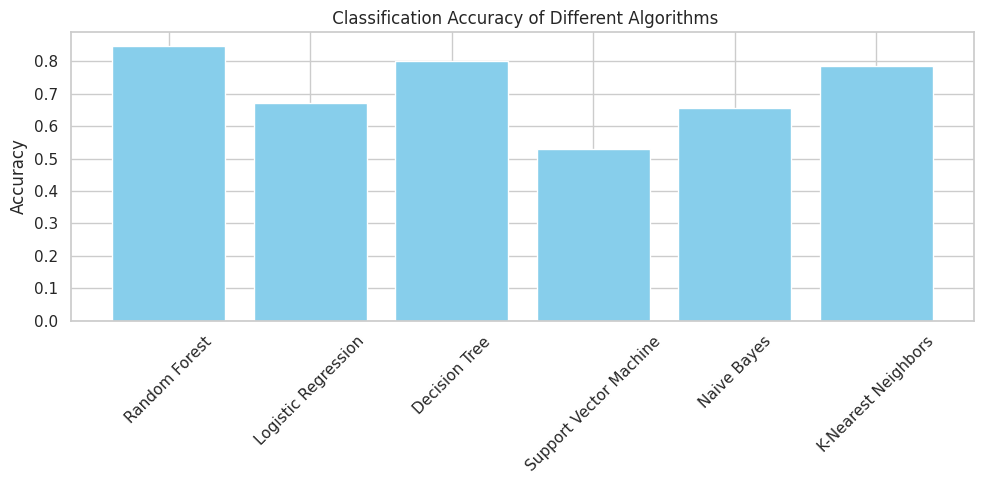

In [ ]:
import matplotlib.pyplot as plt

# Plot model accuracies
plt.figure(figsize=(10, 5))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.ylabel("Accuracy")
plt.title(" Classification Accuracy of Different Algorithms")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
